In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import timeit

# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


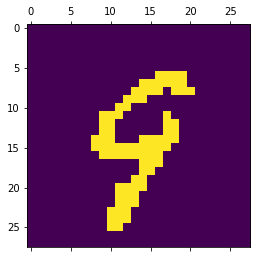

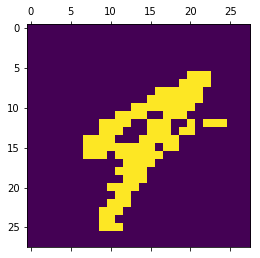

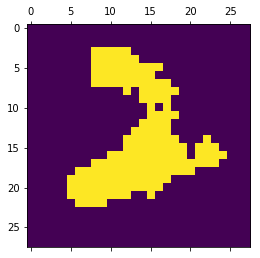

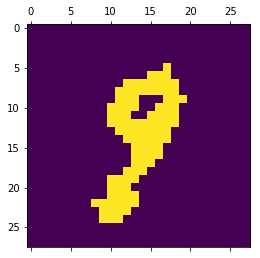

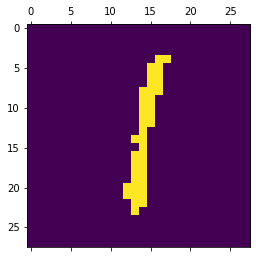

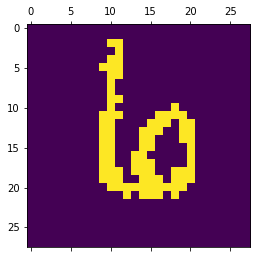

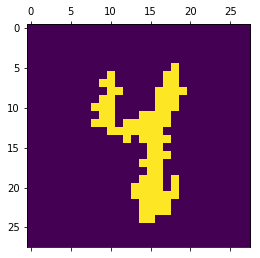

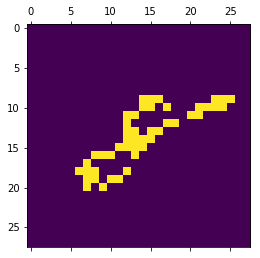

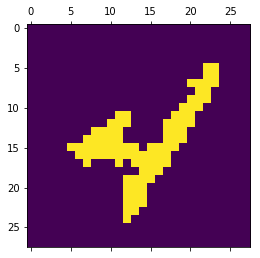

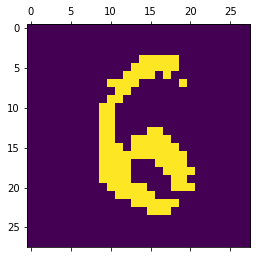

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())

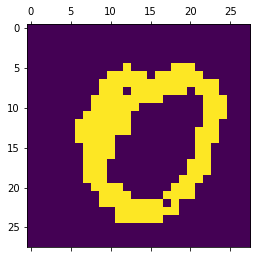

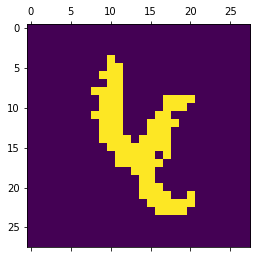

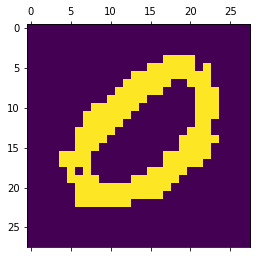

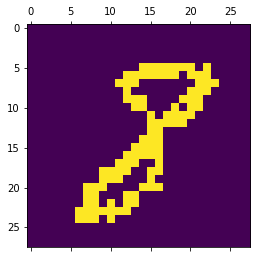

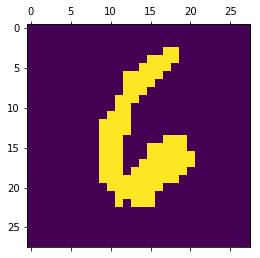

In [5]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())

In [6]:
slen = train_set_unlabeled[0]['image'].shape[0]

# Get data loaders

In [7]:
batchsize = 10

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [8]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [9]:
data_unlabeled['image'].shape

torch.Size([10, 28, 28])

# Define VAE

In [10]:
latent_dim = 5
n_classes = 10

In [11]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [12]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [13]:
28 * 28

784

In [14]:
2 * 28 * 28

1568

In [15]:
### Check things run

In [16]:
vae.get_semisupervised_loss(data_unlabeled['image'], train_set_unlabeled.num_images, 
                            labeled_images = data_labeled['image'], labels = data_labeled['label'],
                            alpha = 1.0, reinforce = False)

(tensor(32455.4570), None, tensor(540.4642), tensor(542.6981), tensor(2.3666))

In [17]:
vae.get_semisupervised_loss(data_test['image'], test_loader.sampler.data_source.num_images, 
                            labeled_images = None, labels = None,
                            alpha = 1.0, reinforce = False)

(tensor(5405.4907), None, tensor(540.5491), 0.0, 0.0)

# Check gradient works 

In [18]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [19]:
vae_params0 = get_vae_params(vae)

In [20]:
assert np.any(np.isnan(vae_params0)) == False

In [21]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [22]:
num_unlabeled_total = train_loader_unlabeled.sampler.data_source.num_images

semi_super_loss, semi_super_ps_loss, \
            unlabeled_loss, labeled_loss, \
            cross_entropy_term = \
                vae.get_semisupervised_loss(data_unlabeled['image'],
                                            num_unlabeled_total,
                                            labeled_images = data_labeled['image'],
                                            labels = data_labeled['label'],
                                            alpha = 1.0,
                                            reinforce = False)

In [23]:
semi_super_loss.backward()
optimizer.step()

In [24]:
vae_params1 = get_vae_params(vae)

In [25]:
assert np.any(np.isnan(vae_params1)) == False

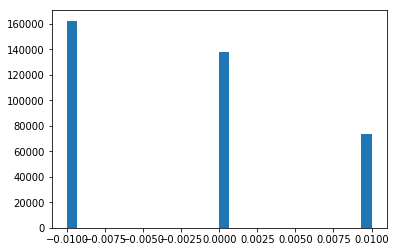

In [26]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [27]:
semi_super_loss, semi_super_ps_loss, \
            unlabeled_loss, labeled_loss, \
            cross_entropy_term = \
                vae.get_semisupervised_loss(data_unlabeled['image'],
                                            num_unlabeled_total,
                                            labeled_images = data_labeled['image'],
                                            labels = data_labeled['label'],
                                            alpha = 1.0,
                                            reinforce = False)

In [28]:
assert np.isfinite(semi_super_loss.detach().numpy())

In [29]:
train_loader_unlabeled.dataset.__len__()

54

In [30]:
mnist_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test')

  * init train recon loss: 494.5915833;
  * init test recon loss: 496.350769;
  * init train class accuracy: 0.2037;
  * init test class accuracy:  0.2;
[1] unlabeled_loss: 453.2412109  	[0.4 seconds]
[2] unlabeled_loss: 331.8572083  	[0.4 seconds]
  * train recon loss: 268.3298035;
  * test recon loss: 290.5068359;
  * train class accuracy: 0.07407;
  * test class accuracy:    0;
[3] unlabeled_loss: 253.3234863  	[0.4 seconds]
[4] unlabeled_loss: 216.9504852  	[0.4 seconds]
  * train recon loss: 204.9965363;
  * test recon loss: 238.5268555;
  * train class accuracy: 0.09259;
  * test class accuracy:  0.1;
[5] unlabeled_loss: 204.684845  	[0.3 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final



In [31]:
classic_loss_array = np.loadtxt('./testloss_array.txt')

In [32]:
classic_loss_array

array([[0.00000000e+00, 2.00000000e+00, 4.00000000e+00],
       [4.94591583e+02, 2.68329803e+02, 2.04996536e+02],
       [4.96350769e+02, 2.90506836e+02, 2.38526855e+02],
       [2.03703701e-01, 7.40740746e-02, 9.25925896e-02],
       [2.00000003e-01, 0.00000000e+00, 1.00000001e-01]])